In [1]:
from pandas_datareader import data
import numpy as np 
import scipy as sp 
import pandas as pd 
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option('display.notebook_repr_html', True)

from datetime import date, datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})  

from cryptocompare import get_daily_trades
from indicators import *

import requests
import talib
import plot

In [27]:
# Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
tickers = ['AAPL', 'MSFT', '^GSPC']

# We would like all available data from 01/01/2000 until 12/31/2016.
start_date = '2010-01-01'
end_date = '2016-12-31'

# User pandas_reader.data.DataReader to load the desired data. As simple as that.
#prices = data.DataReader('TSLA', 'quandl', start_date, end_date,)
prices = get_daily_trades('PPC')
prices = prices.rename(columns={c: c.capitalize() for c in prices.columns})

In [28]:
prices.tail()

,Close,High,Low,Open,Volumefrom,Volumeto
time,,,,,,
2018-09-02,1.28,1.40,1.24,1.37,15485.01,76833.20
2018-09-03,1.46,4.94,1.28,1.28,8201.31,40085.88
2018-09-04,1.27,5.00,1.27,1.46,10200.35,50531.77
2018-09-05,1.27,1.27,1.27,1.27,25582.80,125745.07
2018-09-06,1.11,1.27,1.11,1.27,4677.85,22086.17


In [29]:
#prices = prices.drop(prices[prices.High>1].index)

In [30]:
prices['prev_ath'] = prices.apply(lambda d: prices[:d.name].High.max(), axis=1)
prices['cycle_bottom'] = prices.apply(lambda d: prices[prices[prices.prev_ath==d.prev_ath].index[0]:d.name].Low.min(), axis=1)
prices['time_since_ath'] = prices.apply(lambda d: (d.name - prices[prices.prev_ath==d.prev_ath].index[0]).days , axis=1)
prices['time_since_bottom'] = prices.apply(lambda d: (d.name - prices[prices.cycle_bottom==d.cycle_bottom].index[0]).days , axis=1)

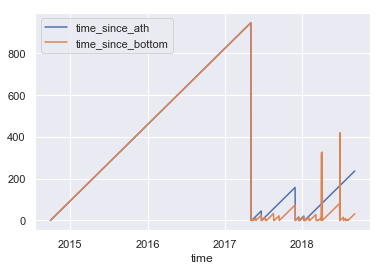

In [31]:
prices[['time_since_ath','time_since_bottom']].plot()

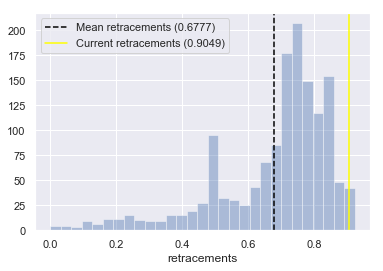

In [32]:
prices['retracements'] = prices.apply(lambda d: (d.prev_ath - d.Close)/d.prev_ath, axis=1)
plot.hist(prices.retracements, plot_last=True)

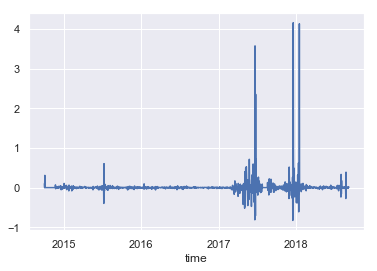

In [33]:
prices.retracements.pct_change(1).plot()

In [34]:
start = datetime(2017,6,1)
end = None#datetime(2013,7,1)
period = prices[start:end]

In [35]:
aths = period[period.prev_ath.diff(2)==0].prev_ath.value_counts().to_frame().reset_index().rename(columns={'index':'price','prev_ath':'days'})
aths.index = [period[period.prev_ath==a].sort_index().index[0] for a in aths.price]
aths = aths.sort_index()
aths['next_ath_date'] = aths.reset_index().shift(-1)['index'].values
premium = 1
aths['retested'] = aths.apply(lambda a: 
    period[a.next_ath_date:][period[a.next_ath_date:].Low <= a.price*premium].index[0] if any(period[a.next_ath_date:].Low <= a.price*premium) else None, axis=1)
pct_retested = round((~aths.retested.isnull()).sum()/aths.shape[0],4)*100
print('{}% of all time highs retested'.format(pct_retested)) 

100.0% of all time highs retested


In [36]:
aths

,price,days,next_ath_date,retested
2017-06-01,2.62,19,2017-06-23,2017-06-26
2017-06-23,3.50,157,2017-11-29,2017-11-29
2017-11-29,5.80,15,2017-12-18,2017-12-19
2017-12-18,7.45,20,2018-01-12,2018-01-16
2018-01-12,11.67,236,NaT,2017-06-01


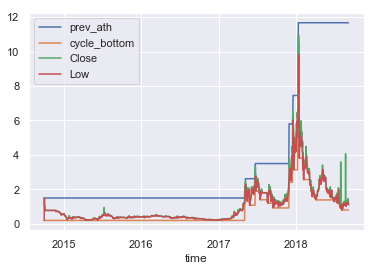

In [37]:
prices[['prev_ath','cycle_bottom', 'Close','Low']].plot()

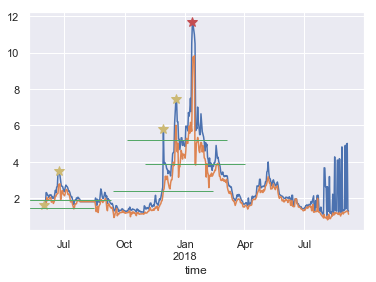

In [38]:
period.High.plot()
period.Low.plot()
period.loc[aths[(~aths.retested.isnull())&(~aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='y')
period.loc[aths[(aths.retested.isnull())|(aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='r')
period.loc[aths.retested.dropna()].Low.plot(marker='_', ls='', markersize=100)


In [39]:
period['RSI'] = talib.RSI(period.Close, timeperiod=7)
period['STOCH1'], period['STOCH2'] = talib.STOCH(period.High, period.Low, period.Close)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11b1deb70>,
      dtype=object)

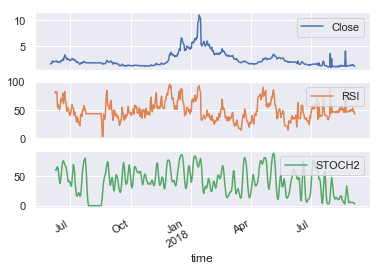

In [40]:
period[['Close','RSI','STOCH2']].plot(subplots=True)

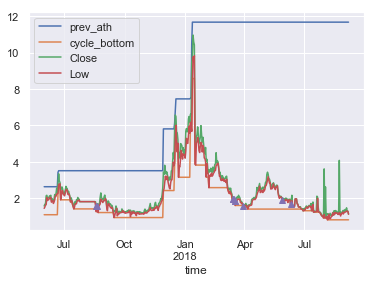

In [41]:
period[['prev_ath','cycle_bottom', 'Close','Low']].plot()
period[period.RSI <= 20].Close.plot(marker='^', ls='')

In [42]:
aths

,price,days,next_ath_date,retested
2017-06-01,2.62,19,2017-06-23,2017-06-26
2017-06-23,3.50,157,2017-11-29,2017-11-29
2017-11-29,5.80,15,2017-12-18,2017-12-19
2017-12-18,7.45,20,2018-01-12,2018-01-16
2018-01-12,11.67,236,NaT,2017-06-01


In [43]:
bottoms = period[period.cycle_bottom.diff(2)==0].cycle_bottom.value_counts().to_frame().reset_index().rename(columns={'index':'price','cycle_bottom':'days'})
bottoms.index = [period[period.cycle_bottom==b].sort_index().index[0] for b in bottoms.price]
bottoms = bottoms.sort_index()
bottoms['next_bottom_date'] = bottoms.reset_index().shift(-1)['index'].values
discount = .95
bottoms['retested'] = bottoms.apply(lambda b:
    period[b.next_bottom_date:][period[b.next_bottom_date:].High >= b.price*discount].index[0] if any(period[b.next_bottom_date:].High >= b.price*discount) else None, axis=1)
pct_retested = round((~bottoms.retested.isnull()).sum()/bottoms.shape[0], 4)*100
print('{}% of cycle bottoms retested'.format(pct_retested))

"""

aths['next_ath_date'] = aths.reset_index().shift(-1)['index'].values
premium = 1
aths['retested'] = aths.apply(lambda a: 
    period[a.next_ath_date:][period[a.next_ath_date:].Low <= a.price*premium].index[0] if any(period[a.next_ath_date:].Low <= a.price*premium) else None, axis=1)
pct_retested = round((~aths.retested.isnull()).sum()/aths.shape[0],4)*100
print('{}% of all time highs retested'.format(pct_retested)) 
"""

95.24000000000001% of cycle bottoms retested


"\n\naths['next_ath_date'] = aths.reset_index().shift(-1)['index'].values\npremium = 1\naths['retested'] = aths.apply(lambda a: \n    period[a.next_ath_date:][period[a.next_ath_date:].Low <= a.price*premium].index[0] if any(period[a.next_ath_date:].Low <= a.price*premium) else None, axis=1)\npct_retested = round((~aths.retested.isnull()).sum()/aths.shape[0],4)*100\nprint('{}% of all time highs retested'.format(pct_retested)) \n"

In [44]:
bottoms

,price,days,next_bottom_date,retested
2017-06-01,1.0800,19,2017-06-23,2017-06-23
2017-06-23,2.7500,1,2017-06-26,2017-06-26
2017-06-26,1.9000,13,2017-07-11,2017-07-11
2017-07-11,1.7800,1,2017-07-16,2017-07-17
2017-07-16,1.4000,32,2017-08-19,2017-08-19
2017-08-19,1.2500,1,2017-08-22,2017-08-22
2017-08-22,1.2000,21,2017-09-15,2017-09-15
2017-09-15,0.9243,73,2017-11-29,2017-11-29
2017-11-29,2.4100,15,2017-12-22,2017-12-22
2017-12-22,3.1400,16,2018-01-12,2018-01-12


In [45]:
bottoms.index[-2]

Timestamp('2018-07-30 00:00:00')

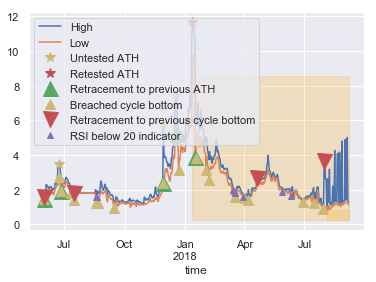

In [46]:
ax=period.High.plot()
period.Low.plot()
period.loc[aths[(~aths.retested.isnull())&(~aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='y', label='Untested ATH')
period.loc[aths[(aths.retested.isnull())|(aths.next_ath_date.isnull())].index].High.plot(marker='*', ls='', markersize=10, color='r', label='Retested ATH')
period.loc[aths.retested.dropna()].Low.plot(marker='^', ls='', markersize=15, label='Retracement to previous ATH')
period.loc[bottoms[(~bottoms.retested.isnull())&(~bottoms.next_bottom_date.isnull())].index].Low.plot(marker='^', ls='', markersize=10, color='y', label='Breached cycle bottom')

ymin, ymax = ax.get_ybound()
# cycle bottom that has yet to be retested 
cb_to_retest = period.loc[bottoms[(bottoms.retested.isnull())|(bottoms.next_bottom_date.isnull())].index]
for time, p in cb_to_retest.iterrows():#.plot(marker='s', ls='', markersize=10, color='r')
    ax.fill_between(period[time:].index, ymin, p.Low, alpha=0.2, color='orange')
period.loc[bottoms[bottoms.retested!=bottoms.next_bottom_date].retested.dropna()].High.plot(marker='v', ls='', markersize=15, label='Retracement to previous cycle bottom')
period[period.RSI <= 20].Close.plot(marker='^', ls='', label='RSI below 20 indicator')
ax.legend()


In [47]:
period['upper_bound'] = period.High.rolling(21).quantile(.90)
period['lower_bound'] = period.Low.rolling(21).quantile(.1)

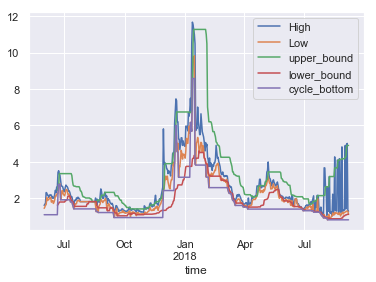

In [48]:
period[['High','Low','upper_bound','lower_bound','cycle_bottom']].plot()

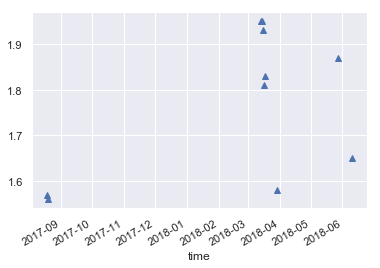

In [49]:
period[period.RSI <= 20].Close.plot(marker='^', ls='')

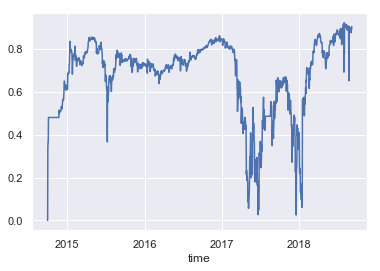

In [50]:
prices.retracements.plot()

In [51]:
df[datetime(2018,1,1)].close.pct_change(7)

NameError: name 'df' is not defined

In [ ]:
when playing a bounce you don't have a taget price you just have a time period to offload initial capital 
